In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import random
from torchvision import transforms as T
from src.core import models, metrics, training, data, loss_functions
from src.dev import experiments as experiments

DATA_DIR = '../SnakeCLEF2023-medium_size-train/'
VAL_DIR='../SnakeCLEF2023-medium_size-val'

# set seed for reproducibility

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

/Users/aartibalana/Documents/transfer-learning/snakeCLEF/.env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


In [2]:
# load metadata
train_df = pd.read_csv('../snake_csv_files/snakeCLEF2023_bbox_cleaned_train_metadata.csv')
valid_df = pd.read_csv('../snake_csv_files/SnakeCLEF2023-cleaned-metadata-val.csv')


train_df.head()
classes = np.unique(train_df['binomial'])
no_classes = len(classes)


print(f'No. of classes: {no_classes}')
print(f'Train set length: {len(train_df):,d}')
print(f'Validation set length: {len(valid_df):,d}')

No. of classes: 1784
Train set length: 120,550
Validation set length: 10,985


In [3]:
# create training 

config = experiments.create_config(
    data='clef2023',
    model='deit_base_384',
    loss='focal',
    opt='sgd',
    no_epochs=3,
    batch_size=64,
    total_batch_size=64,
    learning_rate=0.01,
    scheduler='reduce_lr_on_plateau',
)

# include configuration from model
model_config = models.get_model(config.model, pretrained=False).pretrained_config
config.update(model_config)

# save config file
config.save(DATA_DIR + config.specs_name)

'''
If you have a trained model and want to use its weights for more epochs.
'''

# MODEL_ARCH = 'efficientnet_b0'
# MODEL_NAME = 'clef2023_efficientnet_b0_focal_05-04-2023_08-48-38'
# # create model
# model = models.get_model(MODEL_ARCH, no_classes, pretrained=True)
# training.load_model(model, MODEL_NAME, path='.')
# model_config = model.pretrained_config
# config.update(model_config)
# # save config file
# config.save(DATA_DIR + config.specs_name)

# create loss, optimizer and scheduler functions
loss_fn = loss_functions.LOSSES[config.loss]
# weight_fn = loss_functions.WEIGHTING[config.weight]
opt_fn = training.OPTIMIZERS[config.opt]
sched_fn = training.SCHEDULERS[config.scheduler]


print(config)

Config(
* model_name: clef2023_deit_base_384_focal_05-21-2023_18-30-54
* history_file: clef2023_deit_base_384_focal_05-21-2023_18-30-54.csv
* specs_name: clef2023_deit_base_384_focal_05-21-2023_18-30-54.json
* model: deit_base_384
* loss: focal
* opt: sgd
* no_epochs: 3
* batch_size: 64
* total_batch_size: 64
* learning_rate: 0.01
* scheduler: reduce_lr_on_plateau
* pretrained_checkpoint: deit_base_patch16_384
* input_size: 384
* image_mean: (0.485, 0.456, 0.406)
* image_std: (0.229, 0.224, 0.225))


In [4]:
train_df.head()

,Unnamed: 0,image_path,xmin,ymin,xmax,ymax,keep,binomial,image_file_path,class_id,subset,endemic,code,observation_id
0,0,1990/Zamenis_lineatus/3001242.jpg,81,7,377,319,True,Zamenis lineatus,./SnakeCLEF2023-medium_size/1990/Zamenis_linea...,1779,train,True,IT,2670823
1,1,1990/Xenoxybelis_argenteus/113910655.jpg,52,6,350,383,True,Xenoxybelis argenteus,./SnakeCLEF2023-medium_size/1990/Xenoxybelis_a...,1772,train,False,VE,70108926
2,2,1990/Xenoxybelis_argenteus/113910659.jpg,0,146,379,280,True,Xenoxybelis argenteus,./SnakeCLEF2023-medium_size/1990/Xenoxybelis_a...,1772,train,False,VE,70108926
3,3,1990/Aspidelaps_lubricus/168477.JPG,4,68,364,316,True,Aspidelaps lubricus,./SnakeCLEF2023-medium_size/1990/Aspidelaps_lu...,95,train,False,ZA,117935
4,4,1990/Telescopus_beetzi/177365.JPG,23,1,364,363,True,Telescopus beetzi,./SnakeCLEF2023-medium_size/1990/Telescopus_be...,1606,train,False,ZA,125284


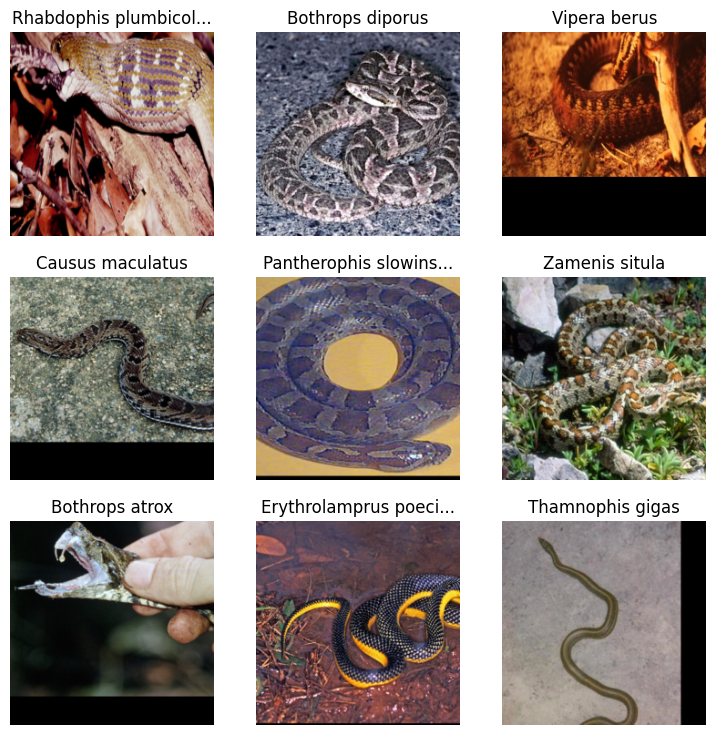

In [5]:
def get_transforms(*, size=224, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """Create basic image transforms for training or validation dataset."""
    train_tfms = T.Compose([
        T.RandomResizedCrop((size, size), scale=(0.8, 1.0)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.5),
        T.RandomApply(torch.nn.ModuleList([
            T.ColorJitter(brightness=0.2, contrast=0.2)
        ]), p=0.2),  # random brightness contrast
        T.ToTensor(),
        T.Normalize(mean, std)])
    valid_tfms = T.Compose([
        T.Resize((size, size)),
        T.ToTensor(),
        T.Normalize(mean, std)])
    return train_tfms, valid_tfms

train_tfms, valid_tfms = get_transforms(
    size=config.input_size, mean=config.image_mean,
    std=config.image_std)

# create data loaders
trainloader = data.get_dataloader(
    train_df[:100], img_path_col='image_path', label_col='binomial',
    path=DATA_DIR , bbox=True, transforms=train_tfms, labels=classes, 
    batch_size=config.batch_size, sampler='weighted', num_workers=4)
validloader = data.get_dataloader(
    train_df[:100], img_path_col='image_path', label_col='binomial',
    path=DATA_DIR , bbox=True, transforms=valid_tfms, labels=classes,
    batch_size=config.batch_size, sampler='weighted', num_workers=4)

trainloader.dataset.show_items()

In [6]:
# create model
model = models.get_model(config.model, no_classes, pretrained=True)
assert np.all([param.requires_grad for param in model.parameters()])


# create loss
criterion = loss_fn()

# create trainer
trainer = training.Trainer(
    model,
    trainloader,
    criterion,
    opt_fn,
    sched_fn,
    validloader=validloader,
    accumulation_steps=config.total_batch_size // config.batch_size,
    path=DATA_DIR,
    model_filename=config.model_name,
    history_filename=config.history_file,
    device=device)

In [7]:
trainer.train(no_epochs=config.no_epochs, lr=config.learning_rate)

epoch,train_loss,valid_loss,accuracy,snake_score,top_3,f1_score,time
0,7.493571,7.448147,0.000000,121,0.000000,0.000000,03:33
1,7.294825,7.011800,0.060000,115,0.200000,0.000593,03:39
2,7.079529,6.669135,0.150000,107,0.370000,0.004652,03:40


Epoch 2 - Save Checkpoint with Best F1 Score: 0.000593
Epoch 3 - Save Checkpoint with Best F1 Score: 0.004652
